In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

%cd drive/MyDrive/ime_project/
!ls

True cuda:0
/content/drive/MyDrive/ime_project
capston_EDA.ipynb  done		   EDA_1030.ipynb  feature_selection2.ipynb  test
checkpoint.pt	   EDA_1003.ipynb  EDA_1101.ipynb  feature_selection.ipynb   test_result
data		   EDA_1010.ipynb  EDA_1102.ipynb  lightning_logs	     trial.ipynb
DL		   EDA_1019.ipynb  EDA_1201.ipynb  result		     var.ipynb


# pre-task

In [3]:
with open('result/final_selection.pkl', 'rb') as file:
    final_selection = pickle.load(file)

features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

target = ['plant2_temperature','plant3_temperature','plant4_temperature','plant5_temperature','plant6_temperature','plant7_temperature','plant8_temperature','plant9_temperature','plant10_temperature']

In [4]:
# 앞선 feature selection으로 선택한 feature들로만 이루어진 training dataset
df_train = pd.read_csv("result/dataset.csv")#, index_col="Unnamed: 0")
df_train.rename(columns={'Unnamed: 0':'cdate'},inplace=True)

df_train["cdate"] = pd.to_datetime(df_train["cdate"])
min_date = df_train["cdate"].min()
df_train['time_idx'] = df_train["cdate"].apply(lambda x: (x - min_date).total_seconds()/60/10) # 10분단위로 timestamp
df_train['time_idx'] = df_train['time_idx'].astype(int)

df_train.set_index("cdate", inplace=True)
df_train = df_train[features]

df_train.columns = df_train.columns.str.lower()
df_train['onoff'] = df_train.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

df_train.drop("plant1_temperature", axis=1, inplace=True)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_train.columns:
    missing_col_name = col + "_missing"
    df_train[missing_col_name] = df_train[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_train[col].fillna(df_train[col].mean(), inplace=True)
    df_train.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_train.columns))
df_train = df_train.loc[:"2023-07-31 23:00:00"]
df_train.head()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-01-01 08:00:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.84,25.83,25.70,40.07,26.31,23.36,19.713945,39.42,23.09,1
2023-01-01 08:10:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.88,25.95,25.70,41.96,26.38,23.73,19.713945,39.62,23.49,1
2023-01-01 08:20:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.90,25.98,25.72,42.36,26.48,23.91,19.713945,39.86,23.60,1
2023-01-01 08:30:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,26.01,26.05,25.90,41.91,26.53,23.99,19.713945,40.07,23.76,1
2023-01-01 08:40:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,26.08,26.10,26.03,41.60,26.65,24.16,19.713945,40.13,23.94,1


In [5]:
lag3_feature = [item for item in df_train.columns if item not in target]
lag3_feature

['ahu1_inv',
 'ahu2_inv',
 'ahu3_inv',
 'ahu4_inv',
 'ahu5_inv',
 'ahu7_inv',
 'ahu8_inv',
 'ahu9_inv',
 'ahu10_inv',
 'ahu11_inv',
 'ahu12_inv',
 'ahu14_inv',
 'plant2_humidity',
 'plant3_humidity',
 'plant7_humidity',
 'ahu13_inv',
 'plant4_humidity',
 'onoff']

In [6]:
df_train[lag3_feature] = df_train[lag3_feature].shift(3)
df_train = df_train.bfill()

print(df_train.isna().any().any())

df_train.head()

False


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-01-01 08:00:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.84,25.83,25.70,40.07,26.31,23.36,19.713945,39.42,23.09,1.0
2023-01-01 08:10:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.88,25.95,25.70,40.07,26.38,23.73,19.713945,39.42,23.49,1.0
2023-01-01 08:20:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,25.90,25.98,25.72,40.07,26.48,23.91,19.713945,39.42,23.60,1.0
2023-01-01 08:30:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,26.01,26.05,25.90,40.07,26.53,23.99,19.713945,39.42,23.76,1.0
2023-01-01 08:40:00,35.0,18.90246,35.0,19.266979,18.445291,18.043542,20.834108,19.026433,19.656569,19.619934,...,26.08,26.10,26.03,41.96,26.65,24.16,19.713945,39.62,23.94,1.0


In [7]:
y = df_train.loc[:,target]
X = df_train.drop(columns=target)

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

window_size = 6

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], window_size, -1))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], window_size, -1))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape (24380, 18) (24380, 9)
Testing Shape (6095, 18) (6095, 9)
Training Shape torch.Size([24380, 6, 3]) torch.Size([24380, 9])
Testing Shape torch.Size([6095, 6, 3]) torch.Size([6095, 9])


In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # out = out[:,-1,:]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [9]:
num_epochs = 1000000
learning_rate = 1e-6

input_size = X_train_tensors_f.size(-1)

early_stopping = EarlyStopping(patience=10000, verbose=False) # 모델이 더 이상 성능이 향상되지 않을 때 학습을 조기에 중단하는 기법

hidden_size = 32
num_layers = 1
num_classes = y_train_tensors.shape[1]

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-8) # weight decay는 모델의 복잡성을 줄이고 과적합 방지하는 정규화 기법
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # schedular는 학습 과정 중 learning rate 조정하여 wegiht 조정하여 성능 개선하는 기

In [10]:
# torch.save(model.state_dict(), 'result/lstm_6win_3timestep_selection_parameters.pth')
model.load_state_dict(torch.load('result/lstm_6win_3timestep_selection_parameters.pth'))

<All keys matched successfully>

# test_1002

In [11]:
df_test = pd.read_csv('test/2023-10-02.csv', index_col='cdate')
# print(df_test.columns)
# features.remove('plant1_temperature')
features_low = [i.lower() for i in features]
features_low.remove('plant1_temperature')
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_test.isna().any().any())
print(len(df_test.columns))

### time-step=3
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
df_test = df_test.bfill()
# df_test = df_test.loc[:'2023-10-02 09:50:00']

df_test.head()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.11,27.97,27.95,44.95,29.03,28.47,0.0,44.38,28.22,0.0
2023-10-02 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.11,27.97,27.98,44.95,29.03,28.18,0.0,44.38,27.96,0.0
2023-10-02 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.10,28.00,27.96,44.95,29.04,28.15,0.0,44.38,27.93,0.0
2023-10-02 06:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.15,28.00,27.98,44.95,29.02,28.48,0.0,44.38,28.23,0.0
2023-10-02 06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.18,28.02,28.00,44.92,29.06,28.53,0.0,44.40,28.30,0.0


In [12]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

### window size = 6
window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

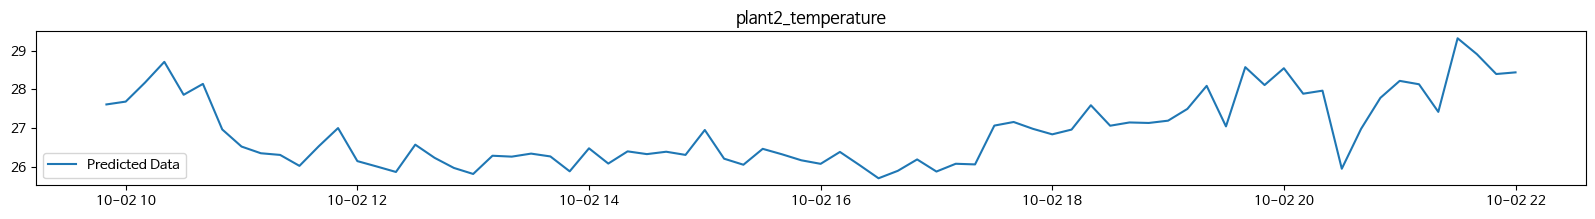

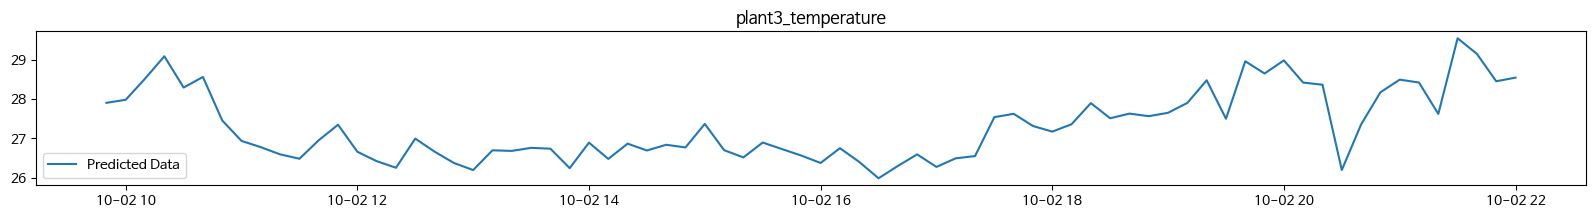

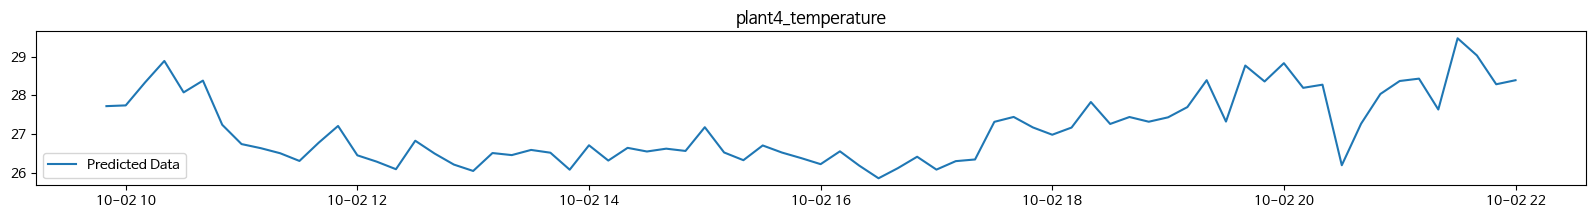

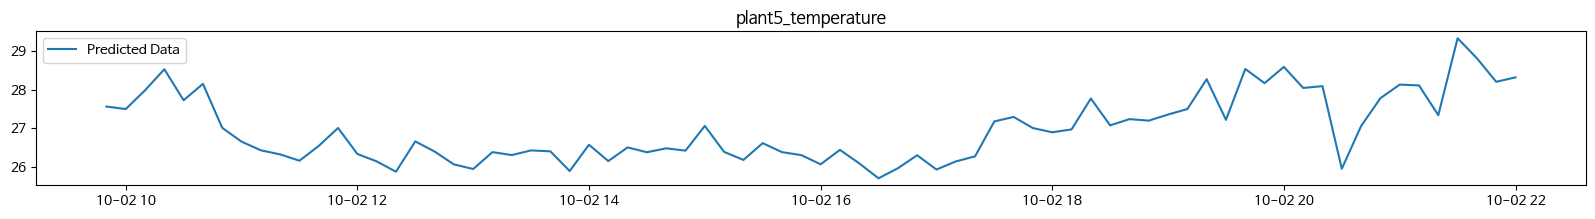

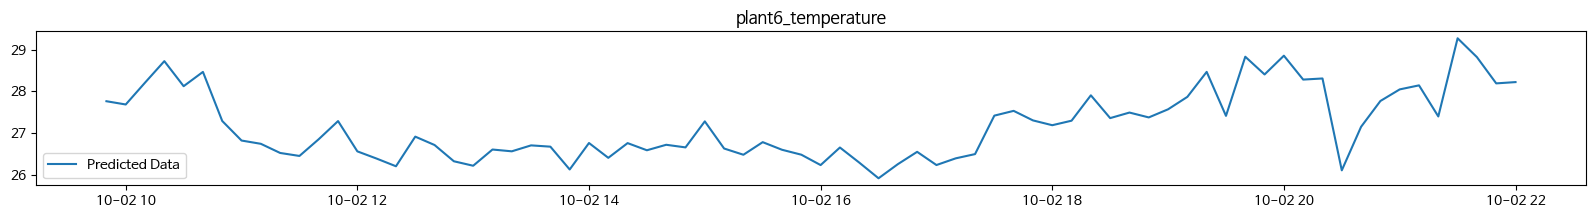

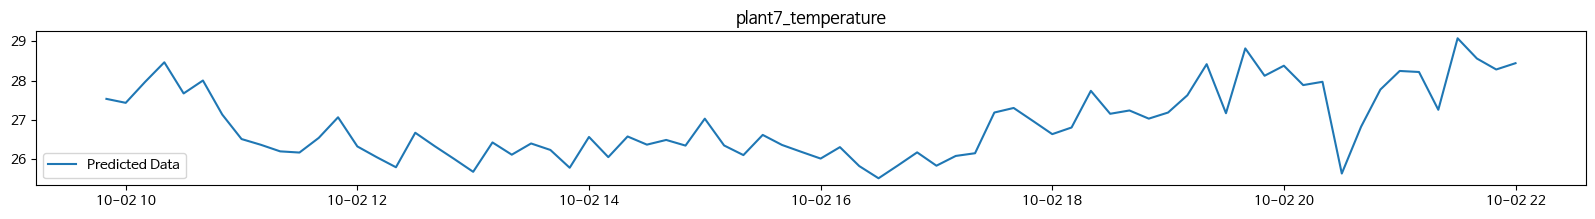

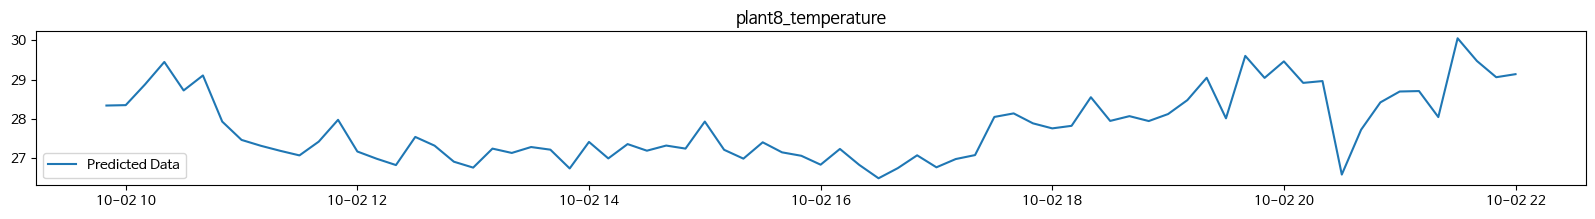

In [13]:
# plt.axvline(x=200, c='r', linestyle='--')
real_date = '2023-10-02 06:00:00'
start_date = '2023-10-02 09:50:00'
end_date = "2023-10-02 22:00:00"
date_range0 = pd.date_range(start=real_date, end=start_date, freq='10T')
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
week1 = len(date_range0)-1
week2 = len(date_range)


for i in range(7):
  plt.figure(figsize=(20,2))
  # plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[week1:week1+week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature')# R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [14]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,8)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(1,8):
    result[f'plant{i+1}_temperature'] = predicted[week1:week2+week1,i]
result.to_csv("test_result/test_1002.csv")
result

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature
2023-10-02 09:50:00,27.910152,27.717390,27.559189,27.761513,27.532814,28.339605,30.914497
2023-10-02 10:00:00,27.988689,27.736246,27.494471,27.683310,27.432102,28.349634,31.577227
2023-10-02 10:10:00,28.527061,28.329123,27.980623,28.207378,27.963011,28.877655,33.244358
2023-10-02 10:20:00,29.099760,28.885300,28.527803,28.723257,28.463511,29.450254,35.262005
2023-10-02 10:30:00,28.300611,28.072826,27.722740,28.122150,27.671329,28.723900,33.952187
...,...,...,...,...,...,...,...
2023-10-02 21:20:00,27.626337,27.629910,27.336205,27.396168,27.255474,28.045395,30.394480
2023-10-02 21:30:00,29.559391,29.471245,29.330933,29.271847,29.074530,30.053228,32.210861
2023-10-02 21:40:00,29.160559,29.027189,28.812178,28.819763,28.559355,29.475117,31.133581
2023-10-02 21:50:00,28.461308,28.282578,28.201612,28.189692,28.280689,29.061102,29.124437


# 1004

In [15]:
df_test = pd.read_csv('test/2023-10-04.csv', index_col='cdate')
# print(df_test.columns)
# features.remove('plant1_temperature')
features_low = [i.lower() for i in features]
features_low.remove('plant1_temperature')
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_test.isna().any().any())
print(len(df_test.columns))

### time-step=3
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
df_test = df_test.bfill()
# df_test = df_test.loc[:'2023-10-02 09:50:00']

df_test.head()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-10-04 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.08,27.92,27.81,43.62,28.96,27.65,0.0,42.87,27.43,0.0
2023-10-04 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.08,27.93,27.82,43.62,28.96,27.81,0.0,42.87,27.59,0.0
2023-10-04 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.09,27.93,27.82,43.62,28.96,27.81,0.0,42.87,27.60,0.0
2023-10-04 06:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.10,27.94,27.82,43.62,28.96,27.66,0.0,42.87,27.41,0.0
2023-10-04 06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.09,27.96,27.84,43.69,29.00,27.61,0.0,42.84,27.48,0.0


In [16]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

### window size = 6
window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

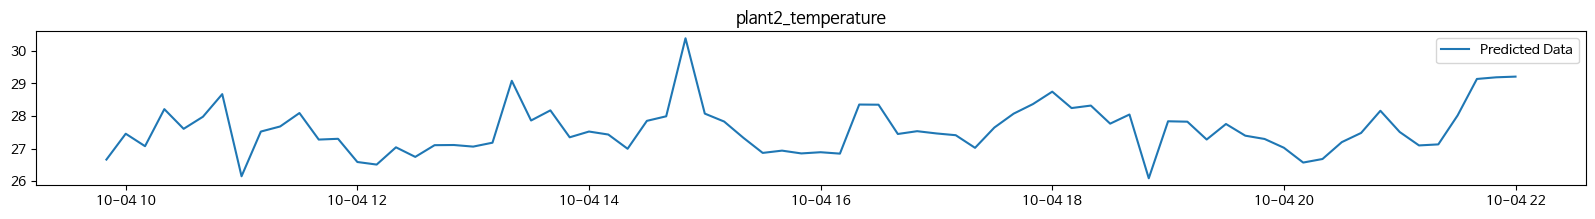

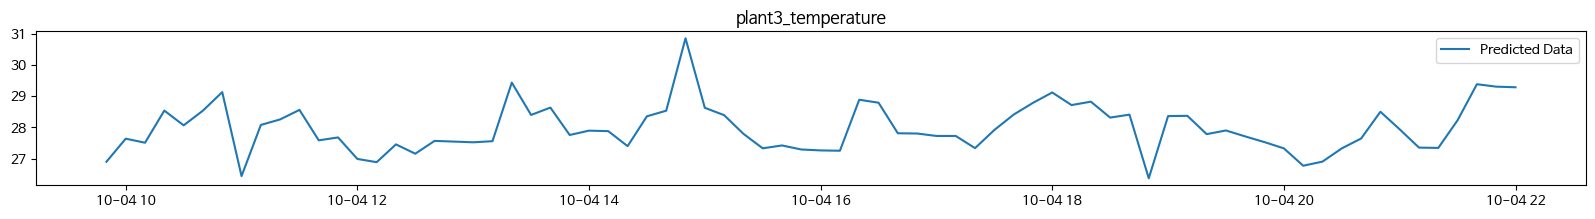

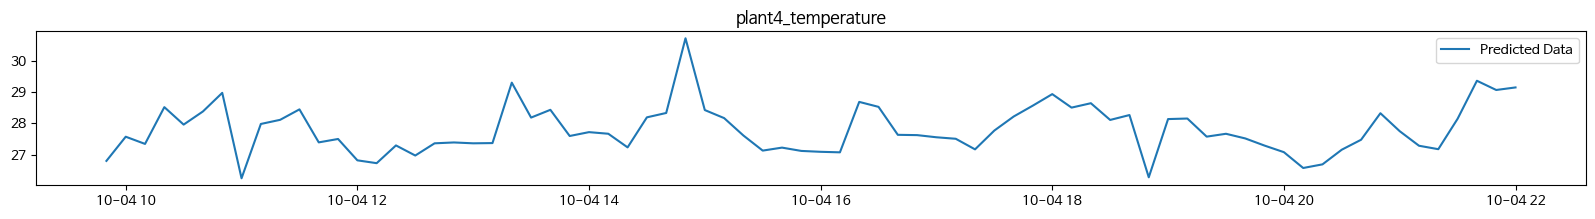

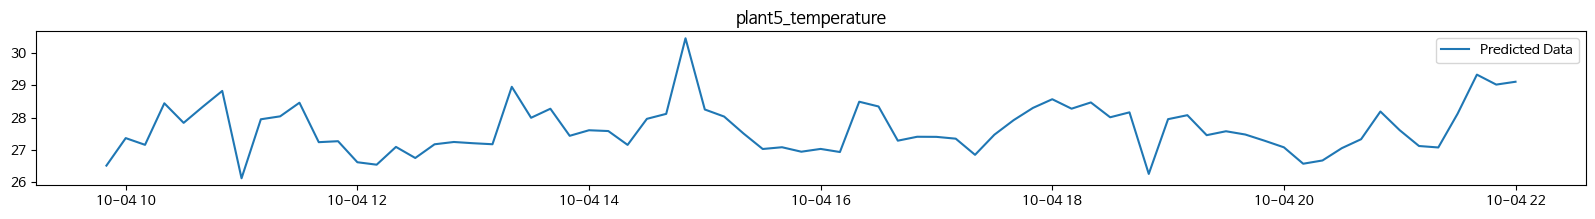

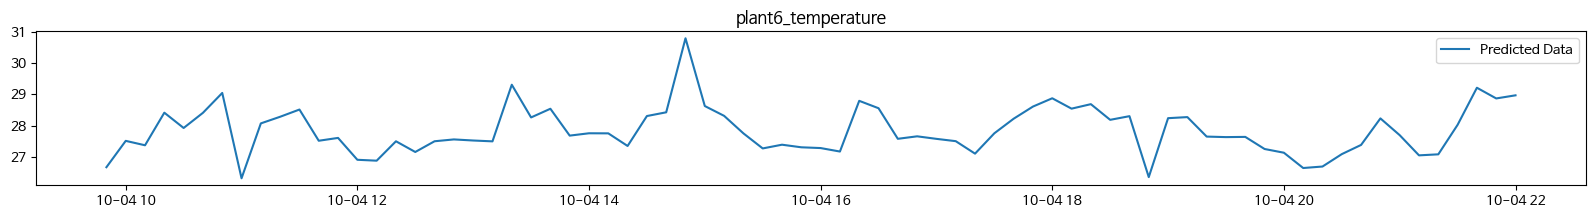

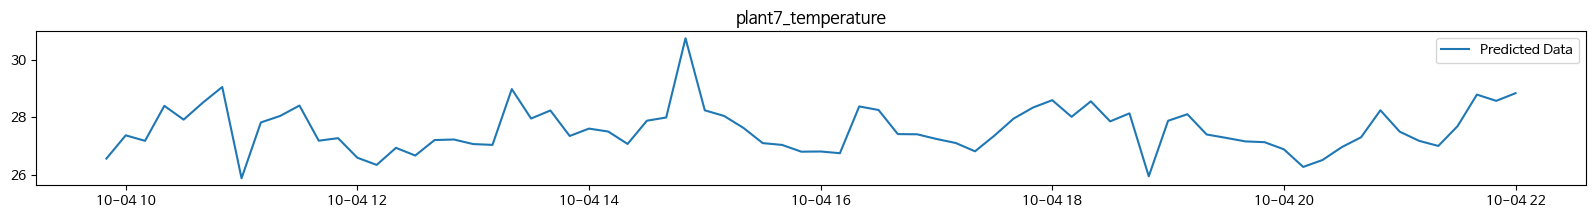

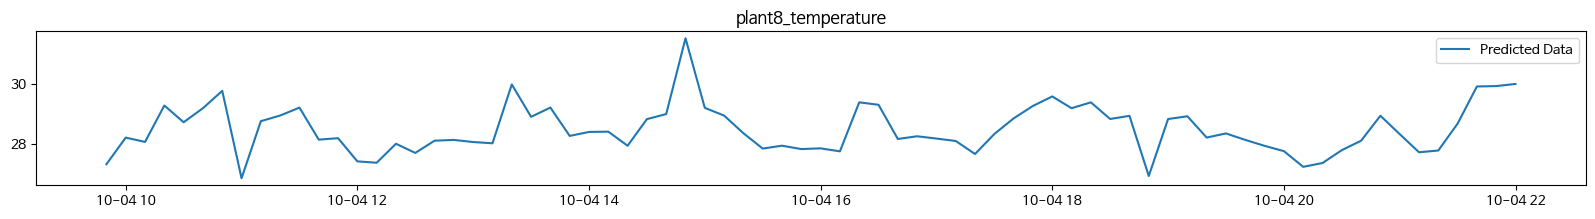

In [17]:
# plt.axvline(x=200, c='r', linestyle='--')
real_date = '2023-10-04 06:00:00'
start_date = '2023-10-04 09:50:00'
end_date = "2023-10-04 22:00:00"
date_range0 = pd.date_range(start=real_date, end=start_date, freq='10T')
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
week1 = len(date_range0)-1
week2 = len(date_range)


for i in range(7):
  plt.figure(figsize=(20,2))
  # plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[week1:week1+week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature')# R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [18]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,8)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(1,8):
    result[f'plant{i+1}_temperature'] = predicted[week1:week2+week1,i]
result.to_csv("test_result/test_1004.csv")
result

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature
2023-10-04 09:50:00,26.897532,26.797289,26.510899,26.662823,26.571169,27.337650,31.442902
2023-10-04 10:00:00,27.640091,27.571785,27.363358,27.508659,27.376577,28.222031,32.107506
2023-10-04 10:10:00,27.510008,27.341114,27.154877,27.367147,27.186035,28.077833,31.934952
2023-10-04 10:20:00,28.544064,28.519222,28.442591,28.413429,28.397614,29.286171,32.742687
2023-10-04 10:30:00,28.069204,27.959835,27.836096,27.922377,27.920162,28.730957,34.060719
...,...,...,...,...,...,...,...
2023-10-04 21:20:00,27.342886,27.172375,27.073160,27.076374,27.008801,27.793270,28.905390
2023-10-04 21:30:00,28.234404,28.146967,28.119516,28.023991,27.696003,28.685274,31.231665
2023-10-04 21:40:00,29.392441,29.364243,29.330574,29.214039,28.787121,29.917732,32.565773
2023-10-04 21:50:00,29.313961,29.068678,29.021751,28.870800,28.570547,29.930082,30.452827


# 1006

In [33]:
df_test = pd.read_csv('test/2023-10-06.csv', index_col='cdate')
# print(df_test.columns)
# features.remove('plant1_temperature')
features_low = [i.lower() for i in features]
features_low.remove('plant1_temperature')
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_test.isna().any().any())
print(len(df_test.columns))

### time-step=3
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
df_test = df_test.bfill()
# df_test = df_test.loc[:'2023-10-02 09:50:00']

df_test.head()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-10-06 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.60,27.43,27.42,44.89,28.45,27.68,0.0,43.99,27.36,0.0
2023-10-06 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.64,27.46,27.43,44.89,28.48,27.98,0.0,43.99,27.62,0.0
2023-10-06 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.66,27.48,27.44,44.89,28.53,28.33,0.0,43.99,27.98,0.0
2023-10-06 06:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.68,27.51,27.46,44.89,28.61,28.49,0.0,43.99,28.14,0.0
2023-10-06 06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.72,27.52,27.48,44.91,28.70,28.07,0.0,44.03,27.73,0.0


In [34]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

### window size = 6
window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

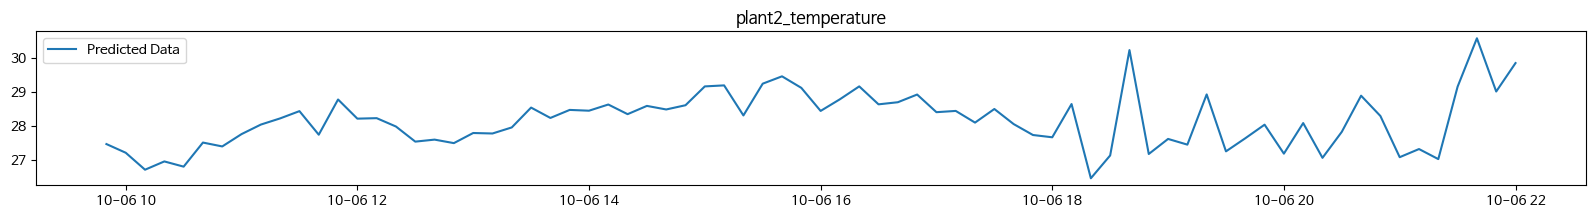

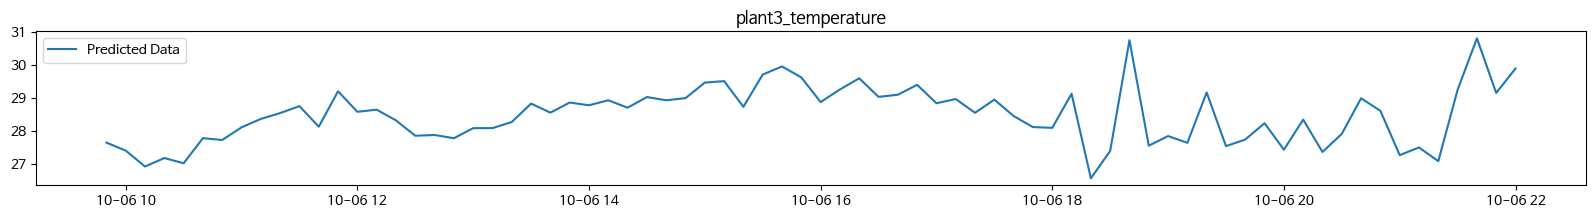

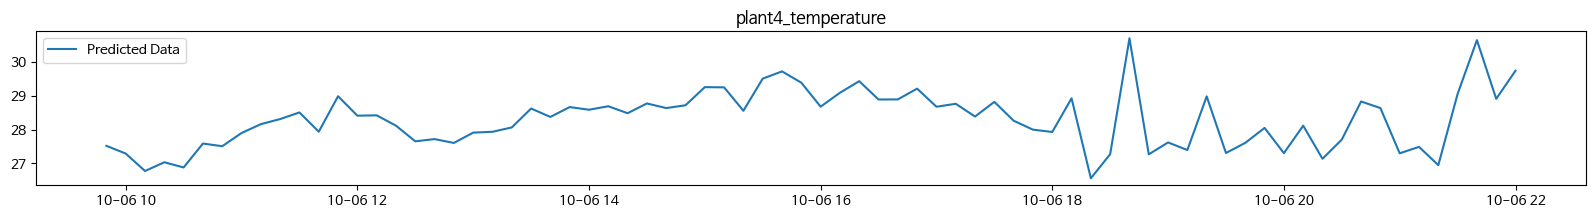

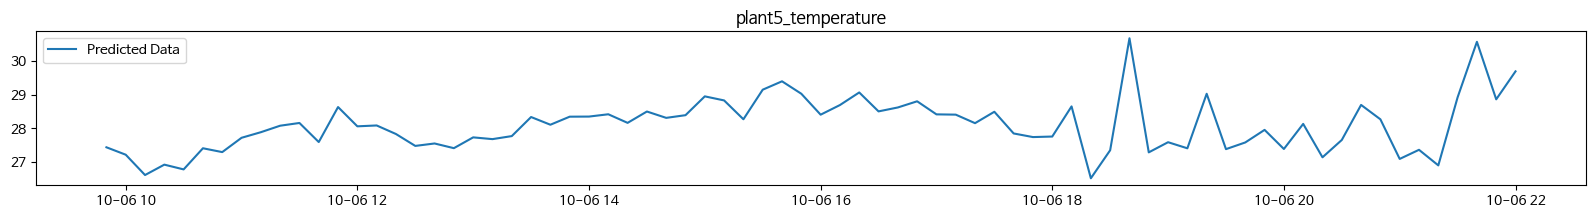

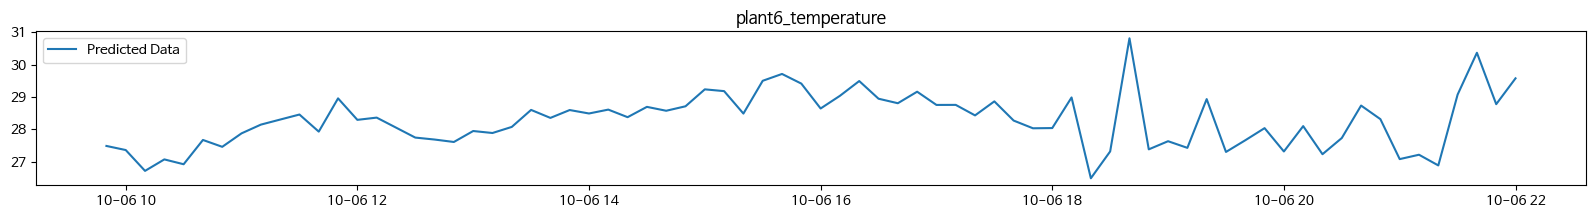

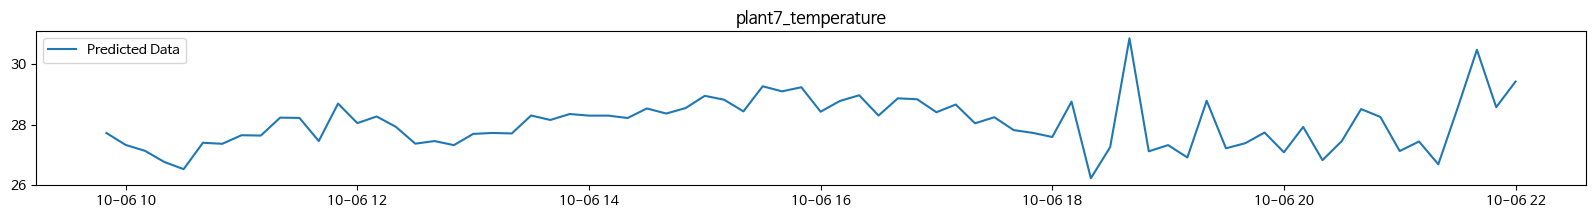

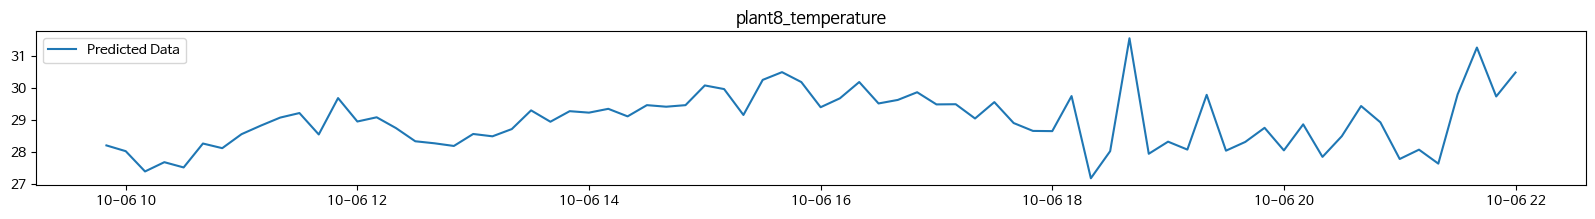

In [35]:
# plt.axvline(x=200, c='r', linestyle='--')
real_date = '2023-10-06 06:00:00'
start_date = '2023-10-06 09:50:00'
end_date = "2023-10-06 22:00:00"
date_range0 = pd.date_range(start=real_date, end=start_date, freq='10T')
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
week1 = len(date_range0)-1
week2 = len(date_range)


for i in range(7):
  plt.figure(figsize=(20,2))
  # plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[week1:week1+week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature')# R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [36]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,8)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(1,8):
    result[f'plant{i+1}_temperature'] = predicted[week1:week2+week1,i]
result.to_csv("test_result/test_1006.csv")
result

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature
2023-10-06 09:50:00,27.650490,27.523668,27.439926,27.484896,27.720982,28.206192,31.276867
2023-10-06 10:00:00,27.406813,27.294949,27.218969,27.358473,27.324541,28.027100,30.715384
2023-10-06 10:10:00,26.923428,26.777271,26.614157,26.714674,27.129385,27.396967,30.731770
2023-10-06 10:20:00,27.181114,27.036570,26.923426,27.069328,26.760281,27.685020,30.156523
2023-10-06 10:30:00,27.022364,26.882795,26.781616,26.919731,26.522594,27.521557,30.159348
...,...,...,...,...,...,...,...
2023-10-06 21:20:00,27.085983,26.951292,26.901228,26.883020,26.683914,27.640238,27.976530
2023-10-06 21:30:00,29.253002,29.064268,28.927380,29.071125,28.547979,29.790667,30.182110
2023-10-06 21:40:00,30.820627,30.661108,30.579290,30.363285,30.480631,31.247559,32.017223
2023-10-06 21:50:00,29.160225,28.919476,28.867342,28.775259,28.577415,29.727673,29.892963


# 1008

In [38]:
df_test = pd.read_csv('test/2023-10-08.csv', index_col='cdate')
# print(df_test.columns)
# features.remove('plant1_temperature')
features_low = [i.lower() for i in features]
features_low.remove('plant1_temperature')
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_test.isna().any().any())
print(len(df_test.columns))

### time-step=3
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
df_test = df_test.bfill()
# df_test = df_test.loc[:'2023-10-02 09:50:00']

df_test.head()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-10-08 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.04,26.77,26.87,44.99,27.85,28.05,0.0,44.15,27.71,0.0
2023-10-08 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.09,26.79,26.87,44.99,27.91,28.08,0.0,44.15,27.76,0.0
2023-10-08 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.10,26.82,26.87,44.99,28.01,28.10,0.0,44.15,27.82,0.0
2023-10-08 06:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.16,26.84,26.90,44.99,28.05,28.10,0.0,44.15,27.80,0.0
2023-10-08 06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.19,26.87,26.97,45.03,28.10,28.01,0.0,44.18,27.68,0.0


In [39]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

### window size = 6
window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

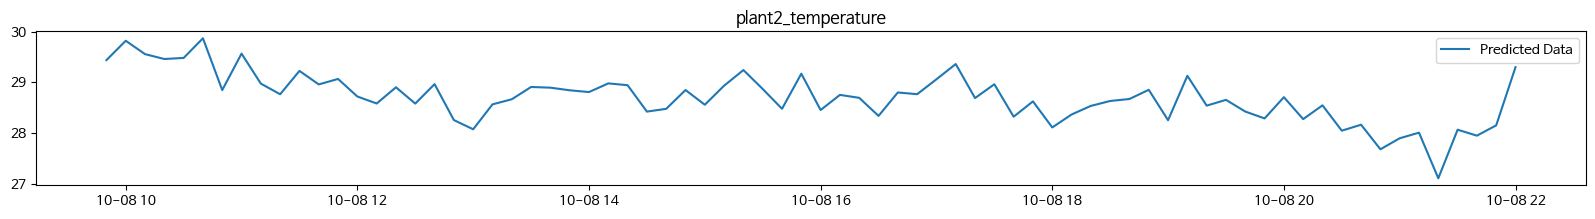

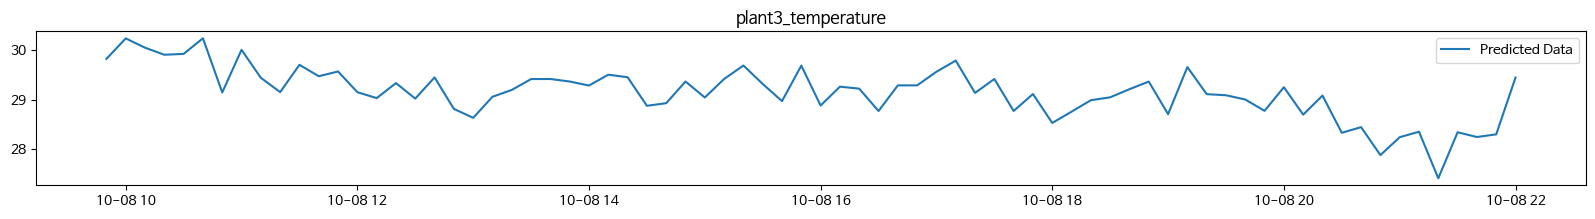

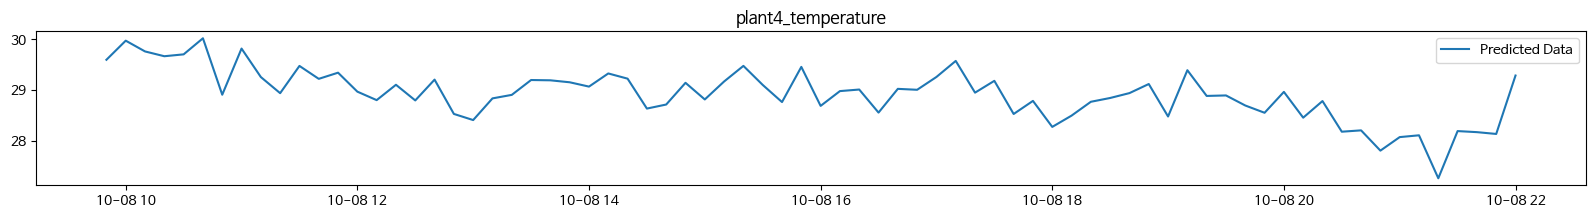

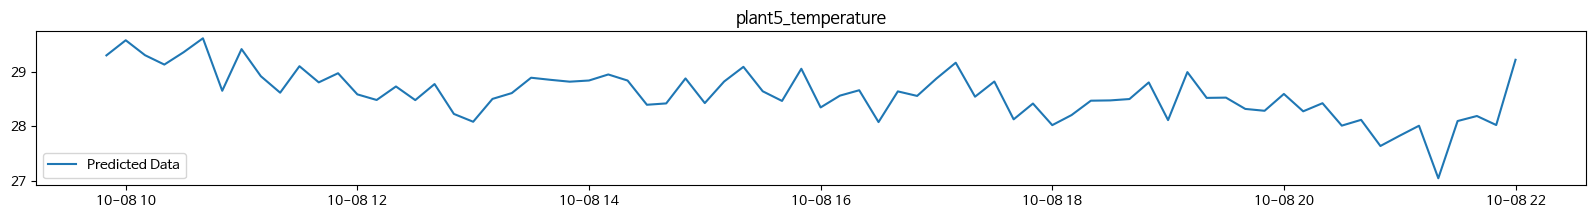

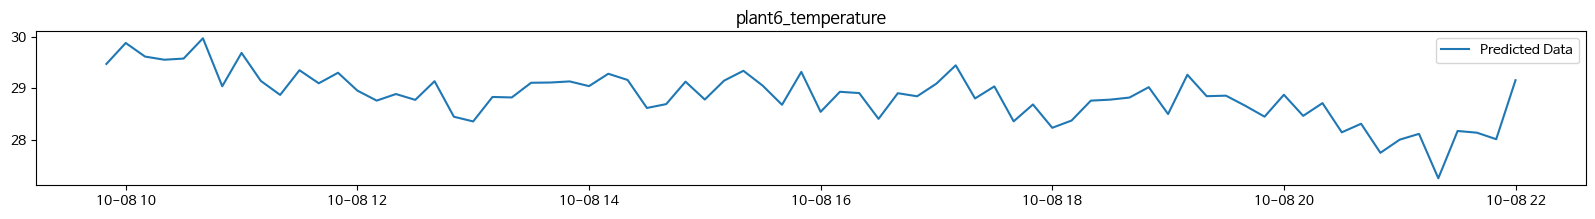

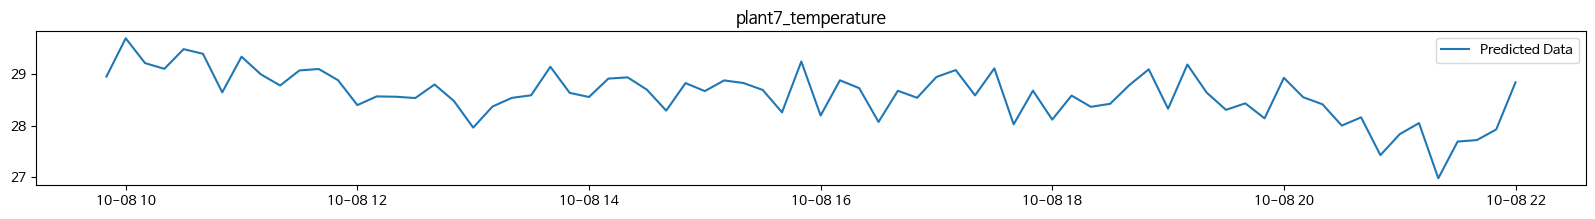

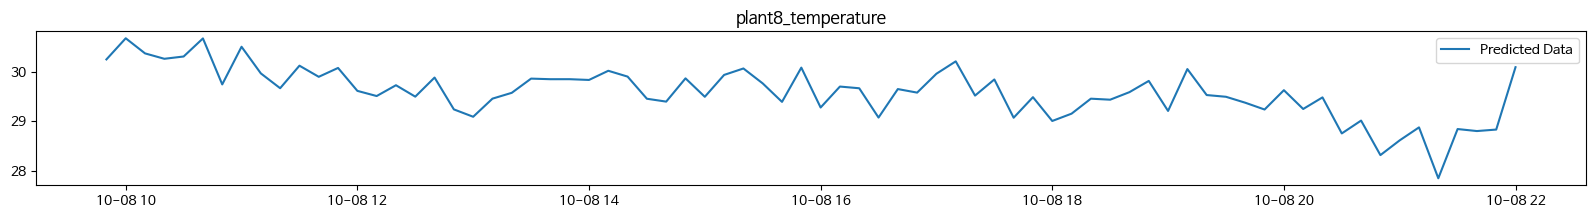

In [40]:
# plt.axvline(x=200, c='r', linestyle='--')
real_date = '2023-10-08 06:00:00'
start_date = '2023-10-08 09:50:00'
end_date = "2023-10-08 22:00:00"
date_range0 = pd.date_range(start=real_date, end=start_date, freq='10T')
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
week1 = len(date_range0)-1
week2 = len(date_range)


for i in range(7):
  plt.figure(figsize=(20,2))
  # plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[week1:week1+week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature')# R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [41]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,8)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(1,8):
    result[f'plant{i+1}_temperature'] = predicted[week1:week2+week1,i]
result.to_csv("test_result/test_1008.csv")
result

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature
2023-10-08 09:50:00,29.826881,29.601007,29.300653,29.475845,28.955212,30.252064,34.834545
2023-10-08 10:00:00,30.241444,29.976925,29.578333,29.883551,29.701033,30.680199,35.713169
2023-10-08 10:10:00,30.053011,29.765106,29.303816,29.618935,29.218197,30.374268,36.685589
2023-10-08 10:20:00,29.910414,29.670790,29.131912,29.557716,29.106833,30.264778,36.125935
2023-10-08 10:30:00,29.927839,29.707632,29.358793,29.580288,29.489449,30.311214,35.715115
...,...,...,...,...,...,...,...
2023-10-08 21:20:00,27.408484,27.269131,27.043921,27.252136,26.977711,27.845076,29.237803
2023-10-08 21:30:00,28.340403,28.197716,28.095165,28.172050,27.691746,28.842043,31.782166
2023-10-08 21:40:00,28.244322,28.176947,28.187447,28.138681,27.720985,28.801378,32.331364
2023-10-08 21:50:00,28.298100,28.141390,28.021692,28.012392,27.927172,28.831556,30.197046


# 1010

In [29]:
df_test = pd.read_csv('test/2023-10-10.csv', index_col='cdate')
# print(df_test.columns)
# features.remove('plant1_temperature')
features_low = [i.lower() for i in features]
features_low.remove('plant1_temperature')
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_test.isna().any().any())
print(len(df_test.columns))

### time-step=3
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
df_test = df_test.bfill()
# df_test = df_test.loc[:'2023-10-02 09:50:00']

df_test.tail()

False
27


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,ahu11_inv,...,plant5_temperature,plant6_temperature,plant7_temperature,plant7_humidity,plant8_temperature,plant10_temperature,ahu13_inv,plant4_humidity,plant9_temperature,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-10-10 21:20:00,30.0,35.0,30.0,0.0,0.0,0.0,42.0,0.0,42.0,0.0,...,27.91,27.670417,27.510833,38.48,28.6975,29.23,0.0,37.21,28.80,1.0
2023-10-10 21:30:00,0.0,35.0,0.0,0.0,0.0,0.0,42.0,0.0,42.0,0.0,...,27.91,27.670417,27.510833,38.43,28.6975,29.03,0.0,36.56,28.67,1.0
2023-10-10 21:40:00,0.0,35.0,0.0,0.0,0.0,0.0,42.0,0.0,42.0,0.0,...,27.91,27.670417,27.510833,39.41,28.6975,28.99,0.0,36.56,28.68,1.0
2023-10-10 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.91,27.670417,27.510833,41.16,28.6975,29.00,0.0,37.90,28.70,0.0
2023-10-10 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.91,27.670417,27.510833,42.18,28.6975,28.94,0.0,37.69,28.66,0.0


In [30]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

### window size = 6
window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

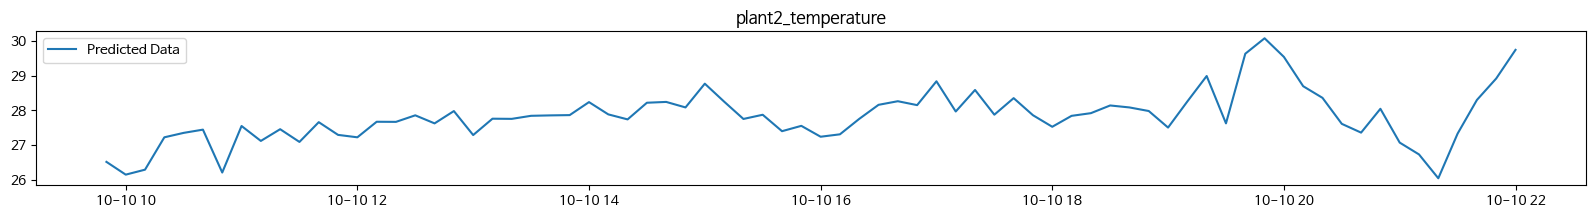

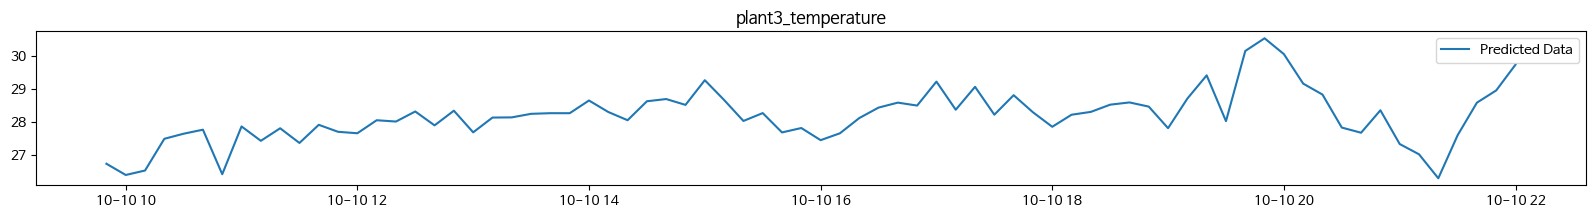

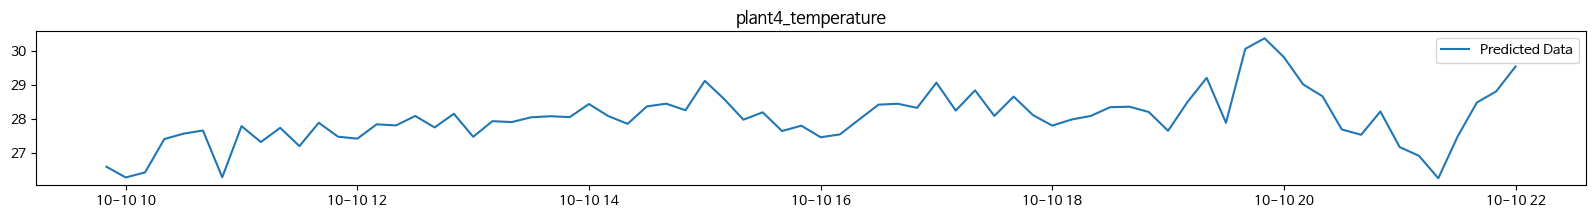

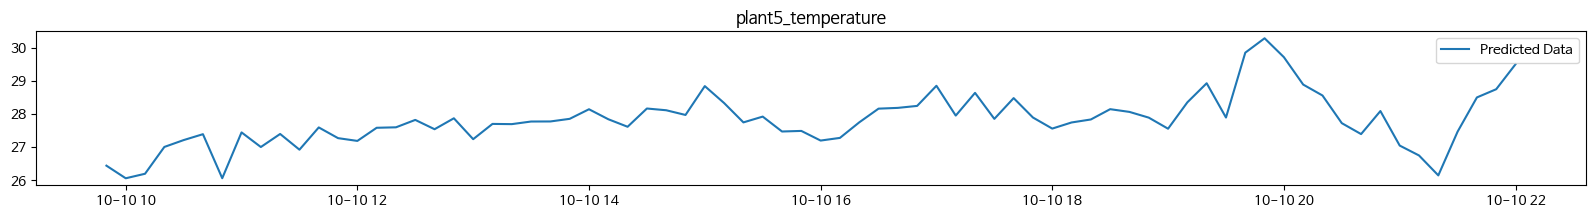

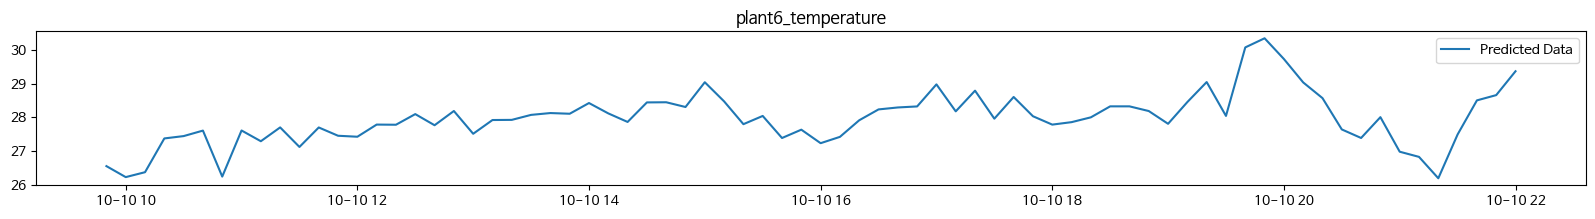

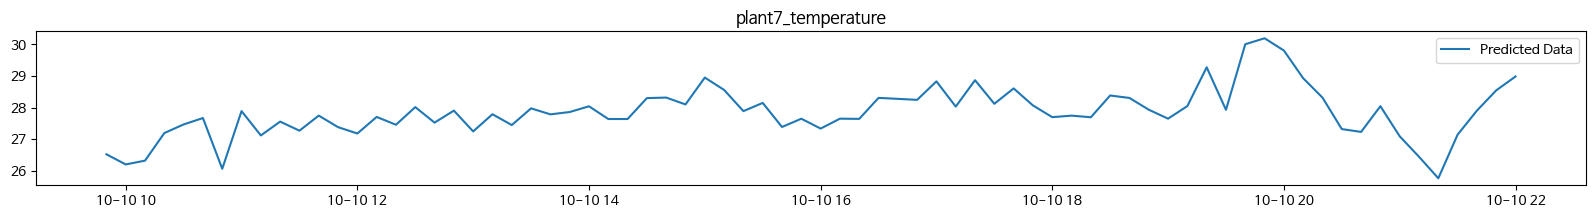

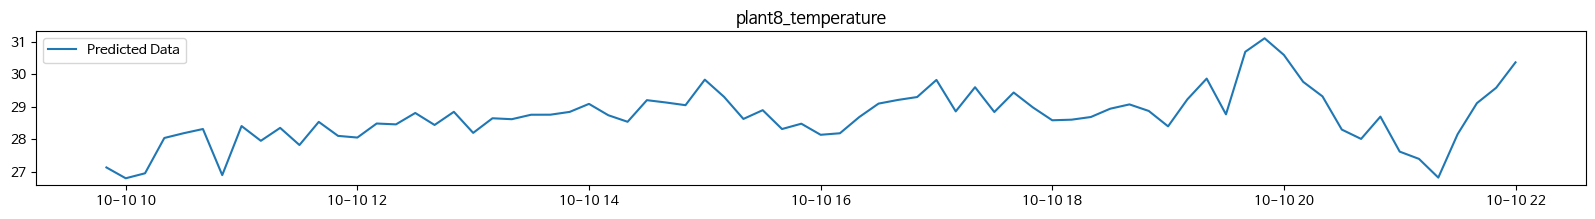

In [31]:
# plt.axvline(x=200, c='r', linestyle='--')
real_date = '2023-10-10 06:00:00'
start_date = '2023-10-10 09:50:00'
end_date = "2023-10-10 22:00:00"
date_range0 = pd.date_range(start=real_date, end=start_date, freq='10T')
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
week1 = len(date_range0)-1
week2 = len(date_range)


for i in range(7):
  plt.figure(figsize=(20,2))
  # plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[week1:week1+week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature')# R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [32]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,8)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(1,8):
    result[f'plant{i+1}_temperature'] = predicted[:week2,i]

result.to_csv("test_result/test_1010.csv")
result

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature
2023-10-10 09:50:00,28.754858,28.524729,28.463522,28.465277,28.386539,29.306362,28.186855
2023-10-10 10:00:00,28.973110,28.691881,28.543642,28.637152,28.677868,29.522272,28.141180
2023-10-10 10:10:00,29.136482,28.895090,28.770191,28.848295,28.818041,29.663607,28.965363
2023-10-10 10:20:00,28.673565,28.383419,28.326395,28.368580,28.388126,29.266205,28.707638
2023-10-10 10:30:00,28.944508,28.680489,28.541428,28.562267,28.687283,29.437159,28.643749
...,...,...,...,...,...,...,...
2023-10-10 21:20:00,28.217684,28.087029,27.862154,27.961657,28.119411,28.842995,33.305939
2023-10-10 21:30:00,28.807238,28.659311,28.489975,28.605877,28.606028,29.442757,33.876064
2023-10-10 21:40:00,28.290663,28.112463,27.902748,28.034294,28.066193,28.983149,33.553928
2023-10-10 21:50:00,27.851484,27.800312,27.568245,27.785522,27.694599,28.588774,33.577770
